In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  5 14:35:35 2025
Compare signal changes between stakes
fig 1 in the manuscript
@author: yuhui
"""
import os
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib
# matplotlib.use('Agg')   # <- force non‐interactive, file‐output backend
import matplotlib.pyplot as plt

import glob
from statsmodels.stats.multitest import multipletests

from scipy.stats import t

In [ ]:
# Define data directory
data_dir = '/media/yuhui/LCT'

# Define stats prefix and coefficient list
stats_prefix = 'stats3.blur1.rbold.'
coef_list = ['ProbLH valueLH', 'ProbMM valueLH', 'ProbMM valueSH',
            'AR GAINLOSS norm', 'AR GAINLOSS sh']

# Define ROI list
roi_list = [
    'lc', 'snvta', 'pos_pfc', 'NAc', 'caudate',
    'gray_bridge', 'putamen'
]

In [ ]:
roi_num = len(roi_list)
coef_num = len(coef_list)

# %% Initialize results storage
df_results = []
all_roi_data = []
all_roi_sem = []
all_t_stats = []
all_p_vals = []
# To store subject-level high stake data for each ROI (for the additional comparison)
all_roi_high_subject = []
all_roi_low_subject = []

all_roi_subj_ids = []  # To store subject IDs for each ROI

all_pcorr_vals = []

In [ ]:
for roi in roi_list:
    bold_mean_file = f"{stats_prefix}{roi}.1D"
    
    # Define the search pattern
    search_pattern = f"{data_dir}/2*/bold.sft/roiProfile/{bold_mean_file}"

    # Find all matching files
    bold_subj_list = sorted(glob.glob(search_pattern))

    roi_subj_ids = [ os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(f))))
                 for f in bold_subj_list ]
    
    subj_num = len(bold_subj_list)

    if subj_num > 0:
        roi_mean_all = np.zeros((coef_num, subj_num))
        
        for subj_idx, subj_file in enumerate(bold_subj_list):
            temp = np.loadtxt(subj_file)
            if np.sum(np.isnan(temp)) > 0 or np.sum(temp==0) > 0:
                print(f"Warning: Issue detected in {subj_file}")
                print("Loaded Data:")
                print(temp)
                break
            else:
                roi_mean_all[:, subj_idx] = temp
        
        # Convert coef_list to a NumPy array if it's a list
        coef_list = np.array(coef_list)

        # Find indices of required coefficients
        lostake_indices = np.where(np.isin(coef_list, ['ProbLH valueLH', 'ProbMM valueLH']))[0]
        histake_indices = np.where(np.isin(coef_list, ['ProbMM valueSH']))[0]
        # Compute mean across selected indices
        roi_mean_all = np.vstack([
            np.mean(roi_mean_all[lostake_indices, :], axis=0),
            np.mean(roi_mean_all[histake_indices, :], axis=0)
        ])
        coef_list1 = ['Low stake', 'High stake']

        roi_mean = np.mean(roi_mean_all, axis=1)
        roi_sem = np.std(roi_mean_all, axis=1) / np.sqrt(subj_num)


        # Store ROI data for combined plot
        all_roi_data.append(roi_mean)
        all_roi_sem.append(roi_sem)
        # Store subject-level high stake data for later comparisons
        all_roi_high_subject.append(roi_mean_all[1, :])
        all_roi_low_subject .append(roi_mean_all[0, :])

        all_roi_subj_ids.append(roi_subj_ids)
        
        # Perform paired t-tests for last two coefficients
        data1, data2 = roi_mean_all[-2, :], roi_mean_all[-1, :]
        t_stat, p_val = stats.ttest_rel(data1, data2)
        # cohen_d for paired t-test
        diff = data1 - data2
        mean_diff = np.mean(diff)
        std_diff = np.std(diff, ddof=1)  # sample SD
        cohen_d = mean_diff / std_diff
        df = subj_num - 1
        
        df_results.append([roi, t_stat, p_val, cohen_d, df])
        all_t_stats.append(t_stat)
        all_p_vals.append(p_val)

# Convert results to DataFrame
df_results = pd.DataFrame(df_results, columns=['ROI', 't_value', 'p_value', 'Cohen_d', 'df'])

# Apply FDR correction (Benjamini-Hochberg)
p_vals_array = np.array(all_p_vals)  # Convert p-values to array
_, p_vals_corrected, _, _ = multipletests(p_vals_array, alpha=0.05, method='fdr_bh')

df_results["p_value_corrected"] = p_vals_corrected
print(df_results)

# Convert all ROI data to a NumPy array for plotting
all_roi_data = np.array(all_roi_data)
all_roi_sem = np.array(all_roi_sem)
all_t_stats = np.array(all_t_stats)
all_p_vals = np.array(all_p_vals)

           ROI   t_value       p_value   Cohen_d  df  p_value_corrected
0           lc -8.442902  7.459669e-08 -1.887890  19       5.221769e-07
1        snvta -6.023748  8.538105e-06 -1.346951  19       1.992225e-05
2      pos_pfc -6.106626  7.165603e-06 -1.365483  19       1.992225e-05
3          NAc -5.311614  3.982641e-05 -1.187713  19       5.575697e-05
4      caudate -5.617688  2.039761e-05 -1.256153  19       3.569582e-05
5  gray_bridge -0.969909  3.442780e-01 -0.216878  19       4.016576e-01
6      putamen -0.034573  9.727812e-01 -0.007731  19       9.727812e-01


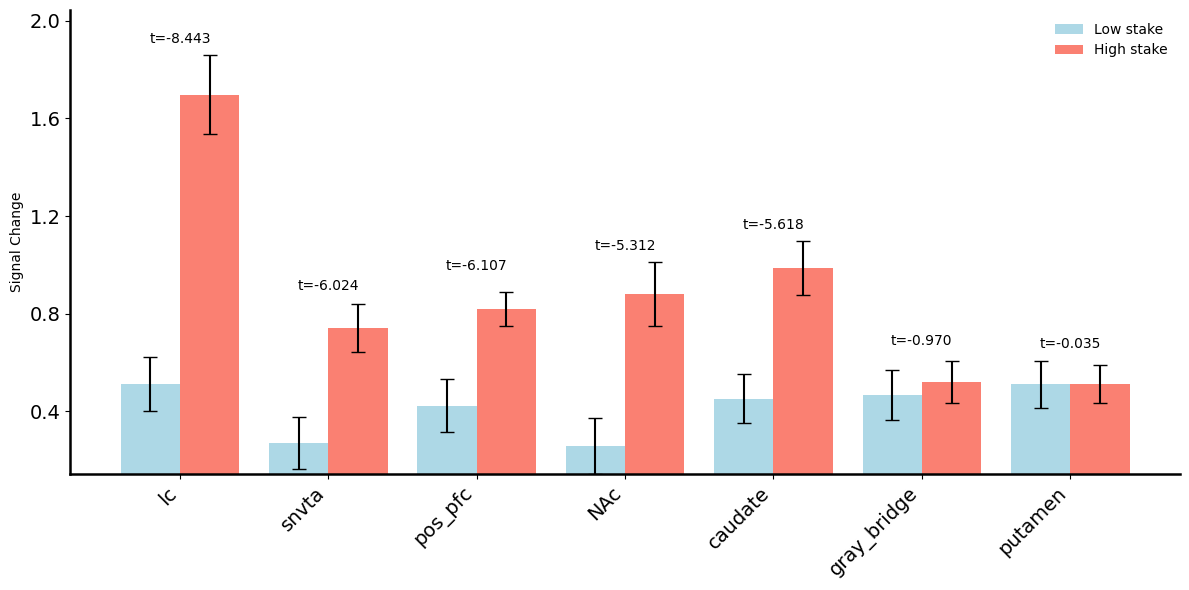

In [ ]:
# %% Combined Bar Plot for All ROIs with Error Bars
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_list))  # X-axis positions
width = 0.4  # Bar width

# Plot each coefficient as a paired bar with error bars
bars1 = ax.bar(x - width/2, all_roi_data[:, 0], width, label=coef_list1[0],
               color='lightblue', yerr=all_roi_sem[:, 0], capsize=5)
bars2 = ax.bar(x + width/2, all_roi_data[:, 1], width, label=coef_list1[1],
               color='salmon', yerr=all_roi_sem[:, 1], capsize=5)
# Set Y-axis limit to accommodate text annotations
max_y = np.max(all_roi_data + all_roi_sem)
min_y = np.min(all_roi_data - all_roi_sem)
ax.set_ylim(min_y, max_y*1.1)
# Annotate t-values and p-values above each pair of bars
# t={all_t_stats[i]:.2f}, 
for i in range(len(roi_list)):
    ax.text(x[i], max(all_roi_data[i]) + max(all_roi_sem[i]) + 0.05, 
            f"t={all_t_stats[i]:.3f}", 
            ha='center', fontsize=10, color='black')

ax.set_xticks(x)
ax.set_xticklabels(roi_list, rotation=45, ha='right')
ax.set_ylabel("Signal Change")
# ax.set_title("Mean Signal Change Across ROIs with Error Bars")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
# Reduce the number of y-ticks using MaxNLocator
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(5))  # Limits to 5 ticks on y-axis
ax.legend()
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)  
ax.spines['bottom'].set_linewidth(1.8)

plt.tight_layout()
plt.savefig("output/roi_stake.png", dpi=300, bbox_inches='tight')

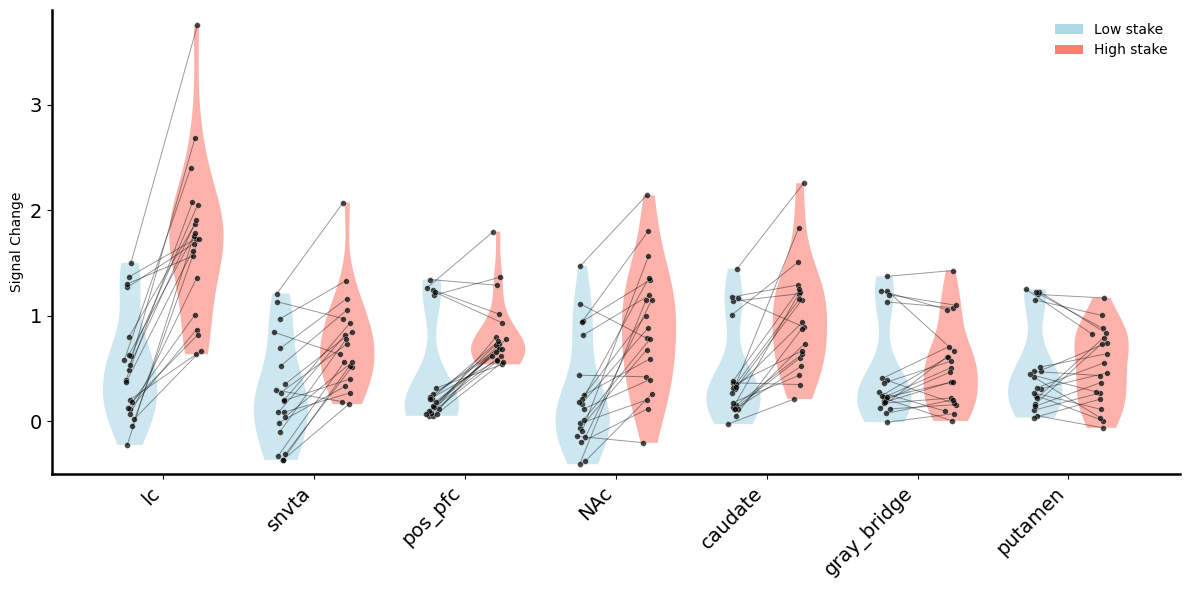

In [ ]:
# %% Violin plot for All ROIs (replaces the bar plot)
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_list))
offset = 0.22          # half-distance between the two violins per ROI
vwidth = 0.36          # violin width
low_color  = 'lightblue'
high_color = 'salmon'

# Keep your y-limits logic (based on mean±SEM) for consistent scaling
max_y = np.max(all_roi_data + all_roi_sem)
min_y = np.min(all_roi_data - all_roi_sem)
ax.set_ylim(-0.5, 3.9)

for i in range(len(roi_list)):
    low  = np.asarray(all_roi_low_subject[i],  float)
    high = np.asarray(all_roi_high_subject[i], float)

    # violins (low, high) at left/right of the ROI center
    parts = ax.violinplot([low, high],
                          positions=[x[i] - offset, x[i] + offset],
                          widths=vwidth,
                          showmeans=False, showmedians=False, showextrema=False)
    parts['bodies'][0].set_facecolor(low_color); parts['bodies'][0].set_alpha(0.6); parts['bodies'][0].set_edgecolor('none')
    parts['bodies'][1].set_facecolor(high_color); parts['bodies'][1].set_alpha(0.6); parts['bodies'][1].set_edgecolor('none')

    # --- Paired slope lines + points (use SAME jitter for Low & High) ---
    rng = np.random.default_rng(7 + i)

    low_v  = np.asarray(all_roi_low_subject[i],  float)
    high_v = np.asarray(all_roi_high_subject[i], float)

    # pairwise drop NaNs so each line connects valid Low–High for the same subject
    mask   = np.isfinite(low_v) & np.isfinite(high_v)
    low_p  = low_v[mask]
    high_p = high_v[mask]

    # same horizontal jitter for both ends so the line hits both dots
    base_jit = rng.normal(0, 0.02, size=low_p.size)
    x_low  = x[i] - offset + base_jit
    x_high = x[i] + offset + base_jit

    # draw lines first (under the dots)
    for xl, xh, yl, yh in zip(x_low, x_high, low_p, high_p):
        ax.plot([xl, xh], [yl, yh], color='k', alpha=0.4, lw=0.7, zorder=4)

    # dots (use the same jitter)
    ax.scatter(x_low,  low_p,  s=18, alpha=0.7, color='k',
            linewidth=0.3, edgecolor='white', zorder=5)
    ax.scatter(x_high, high_p, s=18, alpha=0.7, color='k',
            linewidth=0.3, edgecolor='white', zorder=5)

# axes, ticks, labels, legend
ax.set_xticks(x)
ax.set_xticklabels(roi_list, rotation=45, ha='right')
ax.set_ylabel("Signal Change")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(5))
from matplotlib.patches import Patch
ax.legend(handles=[Patch(facecolor=low_color,  label=coef_list1[0]),
                   Patch(facecolor=high_color, label=coef_list1[1])],
          frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)
ax.spines['bottom'].set_linewidth(1.8)

plt.tight_layout()
plt.savefig("output/roi_stake_violin.png", dpi=300, bbox_inches='tight')